In [1]:
### First we handle our files ###
BASE_PATH = "../data"
FILE = "294_737_599"
tree_path = f"{BASE_PATH}/{FILE}.tree"
alignment_path = f"{BASE_PATH}/{FILE}.fas.alg"
table_path = f"{BASE_PATH}/{FILE}.tsv"
uniprot_path = f"../uniprot_2018_09.json"

### And we store them in different variables ###
try:
    with open(table_path, "r") as table_file:
        table_info = table_file.readlines()
    table_file.close()
except:
    print ("No table path.")
        
try:
    with open(alignment_path, "r") as alignment_file:
        alignment_info = alignment_file.read()
    alignment_file.close()
except:     
    print ("No alignment path.")
        
import json
uniprot_info = {}
with open(uniprot_path, "r") as uniprot_file:
    for line in uniprot_file:
        uniprot_entry = json.loads(line)
        uniprot_info.update(uniprot_entry)
    uniprot_file.close

In [2]:
### LOADING THE SPECIFIED TAG INFORMATION FROM OUR ALIGNMENT ###
def retrieve_features (feature_tag, table_file, evalue_threshold):
    uniprot_hit_hash = {}
    leaf_deleting_list = []
    leaf_saving_list = []
    
    for line in table_file:
        hit_type = line.split("\t")[2]
        hit_name = line.split("\t")[3]
        hit_evalue = line.split("\t")[4]
        
        if hit_evalue == "-":
            hit_evalue = 0.0
        else:
            hit_evalue = float(hit_evalue)

        if (hit_type == ("spb" or "spe") and 
            hit_name not in uniprot_hit_hash and 
            hit_evalue <= evalue_threshold):
            features_newlist = []
#             for feature in uniprot_info[hit_name]["FT"]: # TO CHECK FEATURES WHEN WE PICK A NEW FILE MANUALLY
#                 print (feature)
            for feature in uniprot_info[hit_name]["FT"]:
                if feature["ft"] == feature_tag:
                    features_newlist.append(feature)
            if len(features_newlist) > 0:
                uniprot_hit_hash[hit_name] = features_newlist
            leaf_saving_list.append(hit_name)
        elif hit_evalue > evalue_threshold:
            leaf_deleting_list.append(hit_name)
            
    leaf_deleting_list = set(leaf_deleting_list) - set(leaf_saving_list)
    return uniprot_hit_hash, leaf_deleting_list

In [3]:
uniprot_hit_hash, leaf_delete_list = retrieve_features("BINDING", table_info, 1e-250)
print (uniprot_hit_hash)
print (leaf_delete_list)

{'A3CL77': [{'ft': 'BINDING', 's': '109', 'e': '109', 'ann': 'Substrate. {ECO:0000255|HAMAP-Rule:MF_00087}.'}, {'ft': 'BINDING', 's': '120', 'e': '120', 'ann': 'Substrate. {ECO:0000255|HAMAP-Rule:MF_00087}.'}]}
{'C0SP89', 'P39209', 'Q9I0I6', 'P35841', 'Q9HW93', 'P15492', 'Q88E10', 'B0R474', 'A0A0K6ISY5', 'Q9HUW6', 'Q9R9U8', 'G3XDA3', 'Q55445', 'Q9I3S1', 'Q9HW91', 'Q9X1E2', 'Q9X0N0'}


In [4]:
### LOADING THE TREE WITH ETE3 ###    
from ete3 import PhyloTree, TreeStyle, SeqMotifFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

In [5]:
### TRANSFORMING THE SEQUENCE POSITIONS INTO ALIGNMENTS POSITIONS ###
def get_alignment_position (sequence_position, sequence):
    alignment_position = 0
    aminoacid_counted = 0
    for aminoacid in sequence:
        if aminoacid.isalpha():
            aminoacid_counted += 1
        if not (aminoacid_counted <= sequence_position or aminoacid_counted == 0):
            break
        alignment_position += 1
    return alignment_position

In [6]:
### GETTING A POSITIONS MATRIX FROM THE FEATURES IN OUR TREE ###
def get_positions_matrix (feature_hash, tree):
    position_matrix = []
    for unigene in feature_hash:
        unigene_sequence = (tree&unigene).sequence
        for feature in feature_hash[unigene]:
            feature_start = int(feature["s"])-1
            feature_end = int(feature["e"])-1
            alignment_feature_start = get_alignment_position(feature_start, unigene_sequence)
            alignment_feature_end = get_alignment_position(feature_end, unigene_sequence)
            for position in range (alignment_feature_start, alignment_feature_end+1):
                position_matrix.append(position)
    position_matrix = sorted(list(set(position_matrix)))
    return position_matrix

In [7]:
position_matrix = get_positions_matrix(uniprot_hit_hash, tree)
print (position_matrix)

[1008, 1019]


In [43]:
def dict_diff(a, b):
    return {k: a[k] if k in a else b[k] for k in a.keys() ^ b.keys()}

In [97]:
## THIS IS TAKING THE AMINOACID AS INDIVIDIUAL INSTEAD OF TOGETHER FOR EACH BRANCH ###
import itertools
# ESTE FUNCIONA GUAY
def all_vs_all_calculus_means (first_branch_matrix, second_branch_matrix):

    aminoacid_matrix = []
    position_means = []
    
    for position, item in enumerate(first_branch_matrix):
        aminoacid_matrix.append(first_branch_matrix[position] + second_branch_matrix[position])
    
    for position_aminoacids in aminoacid_matrix:
        position_comparison = []
        for aa1, aa2 in itertools.combinations(position_aminoacids, 2):
            if aa1 == aa2:
                position_comparison.append(0)
            else:
                position_comparison.append(1)
        position_means.append(sum(position_comparison)/len(position_comparison))
    score = sum(position_means)/len(position_means)    

    return score

In [100]:
## THIS IS TAKING THE AMINOACID AS INDIVIDIUAL INSTEAD OF TOGETHER FOR EACH BRANCH ###
# ESTE FUNCIONA GUAY
import itertools

def whole_annotation_all_vs_all_calculus_means (first_branch_matrix, second_branch_matrix):

    merged_matrix = []
    merged_branch = []
    leaf_number = len(first_branch_matrix[0]) + len(second_branch_matrix[0])
    score = 0
    
    for position, item in enumerate(first_branch_matrix[0]):
        merged_matrix.append(item + first_branch_matrix[1][position])
    for position, item in enumerate(second_branch_matrix[0]):
        merged_matrix.append(item + second_branch_matrix[1][position])

    position_comparison = [] 
    for aa1, aa2 in itertools.combinations(merged_matrix, 2):
        if aa1 == aa2:
            position_comparison.append(0)
        else:
            position_comparison.append(1)
            
    score = sum(position_comparison)/len(position_comparison)
    score = round(score, 2)

    return score

In [9]:
## THIS IS TAKING THE AMINOACID AS INDIVIDIUAL INSTEAD OF TOGETHER FOR EACH BRANCH ###
# ESTE FUNCIONA GUAY
import itertools

def all_vs_all_calculus (first_branch_matrix, second_branch_matrix):

    aminoacid_matrix = []
    position_means = []
    score = 0
    leaf_number = len(first_branch_matrix[0]) + len(second_branch_matrix[0])

    for position, item in enumerate(first_branch_matrix):
        aminoacid_matrix.append(first_branch_matrix[position] + second_branch_matrix[position])
    
    for position_aminoacids in aminoacid_matrix:
        for aa1, aa2 in itertools.combinations(position_aminoacids, 2):
            if aa1 != aa2:
                score += 1/leaf_number
    score = round(score, 2)

    return score

In [93]:
## THIS IS TAKING THE AMINOACID AS INDIVIDIUAL INSTEAD OF TOGETHER FOR EACH BRANCH ###
# ESTE FUNCIONA GUAY
import itertools

def whole_annotation_all_vs_all_calculus (first_branch_matrix, second_branch_matrix):

    merged_matrix = []
    merged_branch = []
    leaf_number = len(first_branch_matrix[0]) + len(second_branch_matrix[0])
    score = 0
    
    for position, item in enumerate(first_branch_matrix[0]):
        merged_matrix.append(item + first_branch_matrix[1][position])
    for position, item in enumerate(second_branch_matrix[0]):
        merged_matrix.append(item + second_branch_matrix[1][position])

    for aa1, aa2 in itertools.combinations(merged_matrix, 2):
        if aa1 != aa2:
            score += 1/leaf_number
    score = round(score, 2)
    
    return score

In [55]:
### THIS IS TAKING THE AMINOACID COMO CONJUNTO FOR EACH POSITION OR ANOTATION ###
# ESTE FUNCIONA GUAY
from collections import Counter

def simple_calculus (first_branch_matrix, second_branch_matrix):
    leaf_number = len(first_branch_matrix[0]) + len(second_branch_matrix[0])
    score = 0
    for position, item in enumerate(first_branch_matrix):
        differences = dict_diff(Counter(item), Counter(second_branch_matrix[position]))
        score += sum( [differences[different_aminoacid] / leaf_number for different_aminoacid in differences ] )
    score = round(score, 2)

    return score

In [90]:
### THIS IS TAKING THE AMINOACID COMO CONJUNTO FOR EACH POSITION ###
# ESTE FUNCIONA GUAY
from collections import Counter

def whole_annotation_simple_calculus (first_branch_matrix, second_branch_matrix):
    merged_matrix = []
    merged_branch = []
    leaf_number = len(first_branch_matrix[0]) + len(second_branch_matrix[0])
    score = 0
    
    for position, item in enumerate(first_branch_matrix[0]):
        merged_matrix.append(item + first_branch_matrix[1][position])
    for position, item in enumerate(second_branch_matrix[0]):
        merged_branch.append(item + second_branch_matrix[1][position])
    merged_matrix = [merged_matrix] + [merged_branch]

    differences = dict_diff(Counter(merged_matrix[0]), Counter(merged_matrix[1]))

    score += sum( [differences[different_aminoacid] / leaf_number for different_aminoacid in differences ] )
    score = round(score, 2)

    return score

In [79]:
def get_scorer(calculus_algorithm):
    
    if calculus_algorithm == "simple":
        scorer = simple_calculus
    
    elif calculus_algorithm == "all_vs_all":
        scorer = all_vs_all_calculus
    
    elif calculus_algorithm == "whole_annotation_simple":
        scorer = whole_annotation_simple_calculus
    
    elif calculus_algorithm == "whole_annotation_all_vs_all":
        scorer = whole_annotation_all_vs_all_calculus

    elif calculus_algorithm == "all_vs_all_means":
        scorer = all_vs_all_calculus_means
        
    elif calculus_algorithm == "whole_annotation_all_vs_all_means":
        scorer = whole_annotation_all_vs_all_calculus_means

    return scorer

In [83]:
## THIS IS TAKING THE AMINOACID AS INDIVIDIUAL INSTEAD OF TOGETHER FOR EACH BRANCH ###
def calculate_node_score (node, position_matrix, calculus_algorithm):
    branch_matrix = []
    for branch in node.get_children():
        aminoacid_matrix = []
        for position in position_matrix:
            position_aminoacids = []
            for leaf in branch.iter_leaves():
                position_aminoacids.append(leaf.sequence[position])
            aminoacid_matrix.append(position_aminoacids)
        branch_matrix.append(aminoacid_matrix)
    
    first_branch_matrix = branch_matrix[0]
    second_branch_matrix = branch_matrix[1]
    
    scorer = get_scorer(calculus_algorithm)
    score = scorer(first_branch_matrix, second_branch_matrix)

    return score

In [85]:
# # Calculating scores for internal nodes
# USADO PARA VER SI FUNCIONABAN LOS SCORES. HABRA QUE BORRARLO
# node_number = 0
# node_scores = {}
# limit = 0
# for node in tree.traverse():
#     if node.is_leaf() == False:
#         node_score = round(calculate_node_score(node, position_matrix, "simple"), 2)
#         node.add_feature("node_score", node_score)
#         node_scores[node_number] = node_score
#         node_number += 1
#         calculate_node_score(node, position_matrix, "whole_annotation_all_vs_all_means")


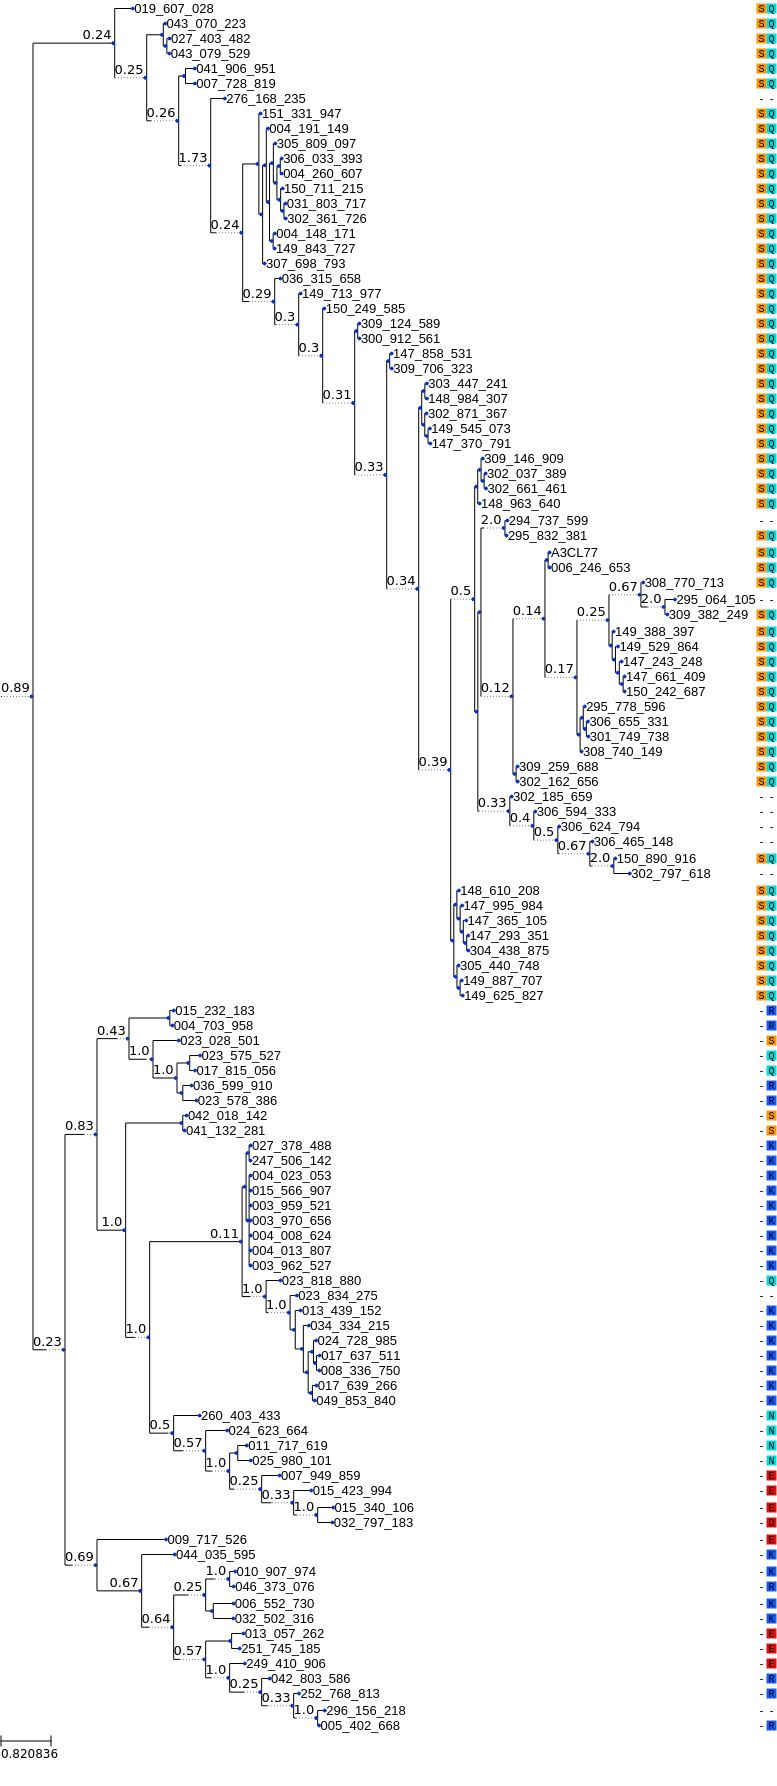

In [87]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    if leaf.name in leaf_delete_list:
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "simple"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score > 0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree_deleted.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

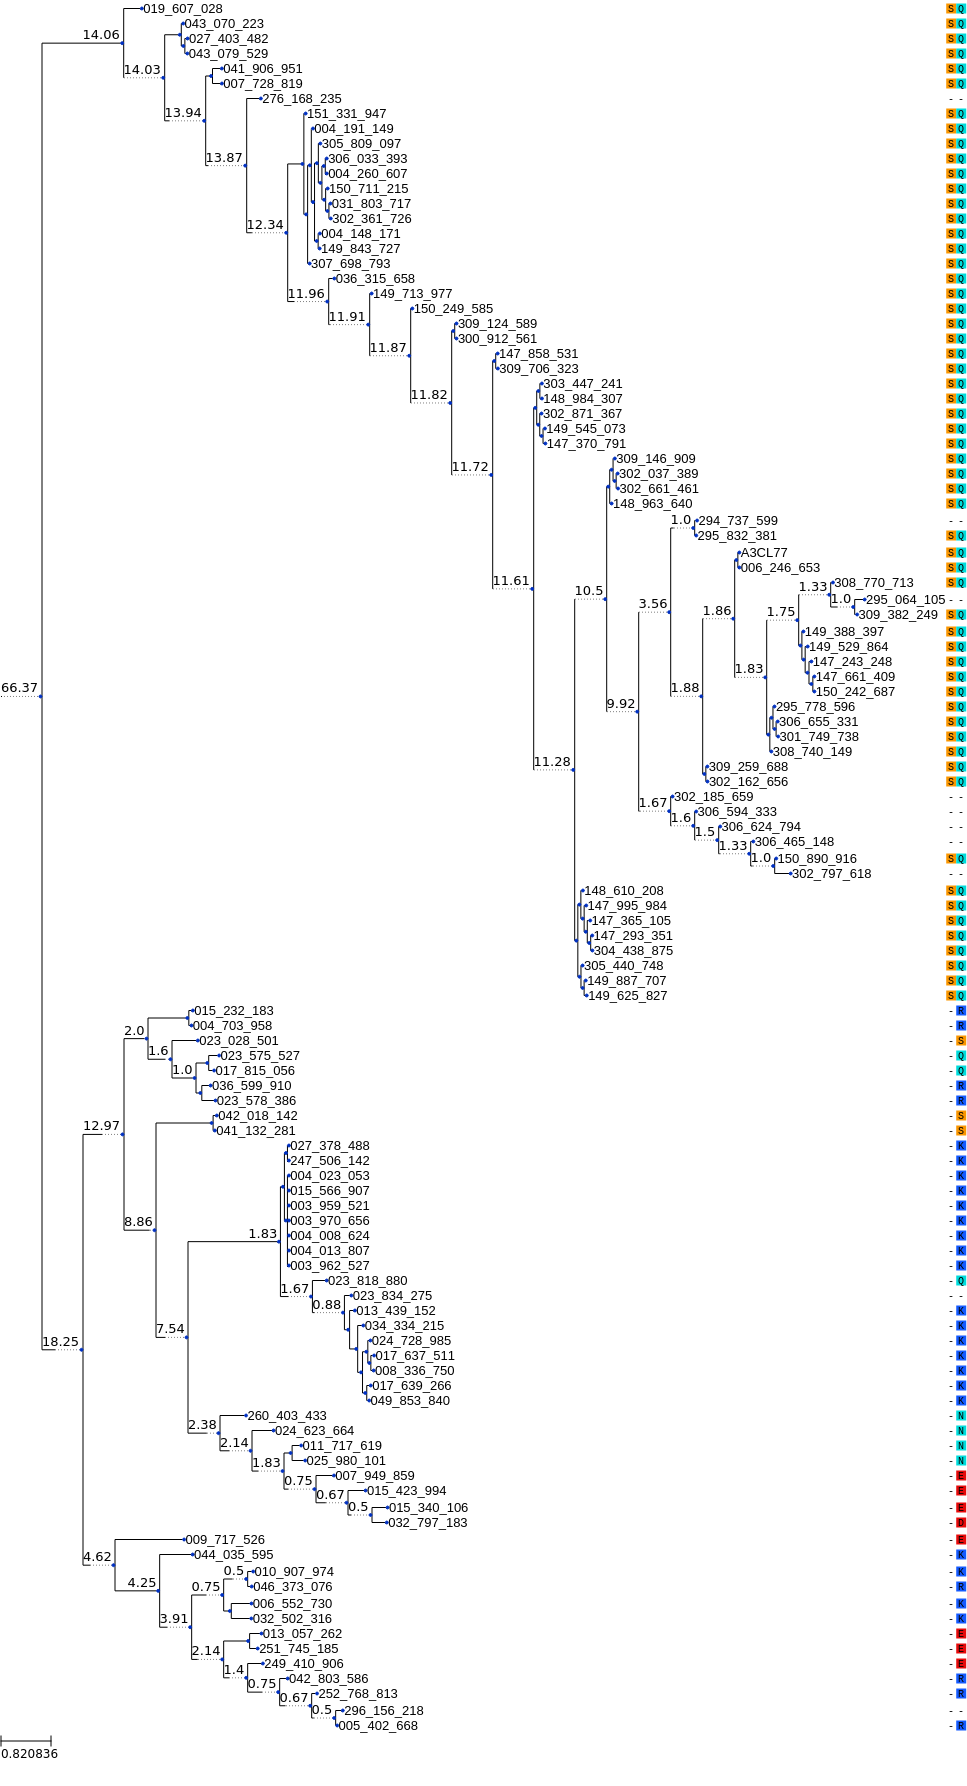

In [88]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    if leaf.name in leaf_delete_list:
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "all_vs_all"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score > 0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree_deleted.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

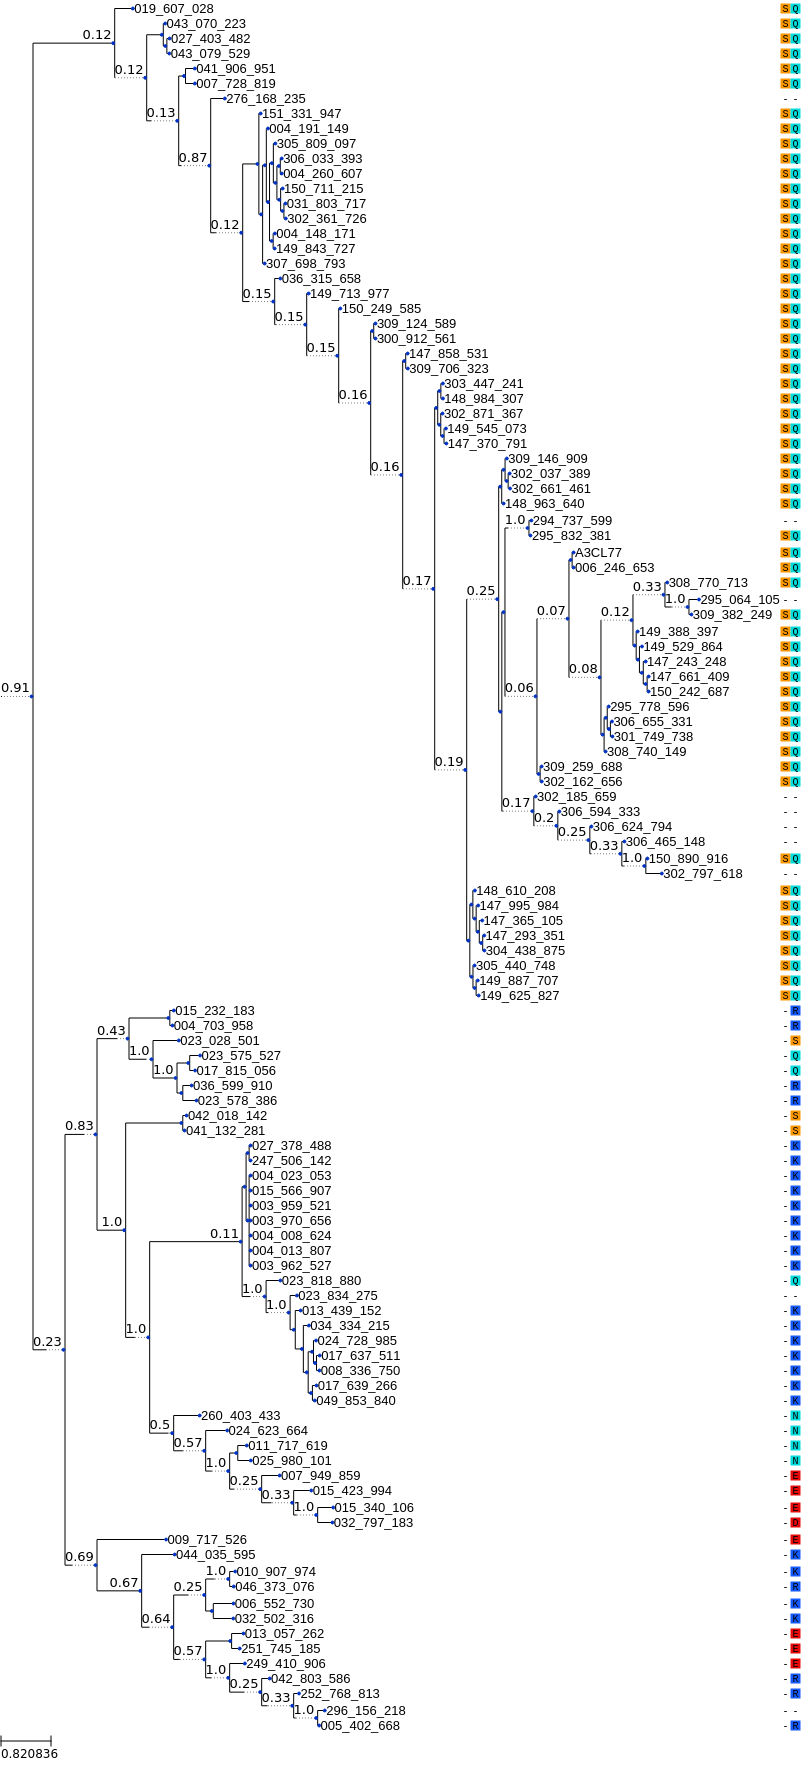

In [91]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    if leaf.name in leaf_delete_list:
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "whole_annotation_simple"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score > 0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree_deleted.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

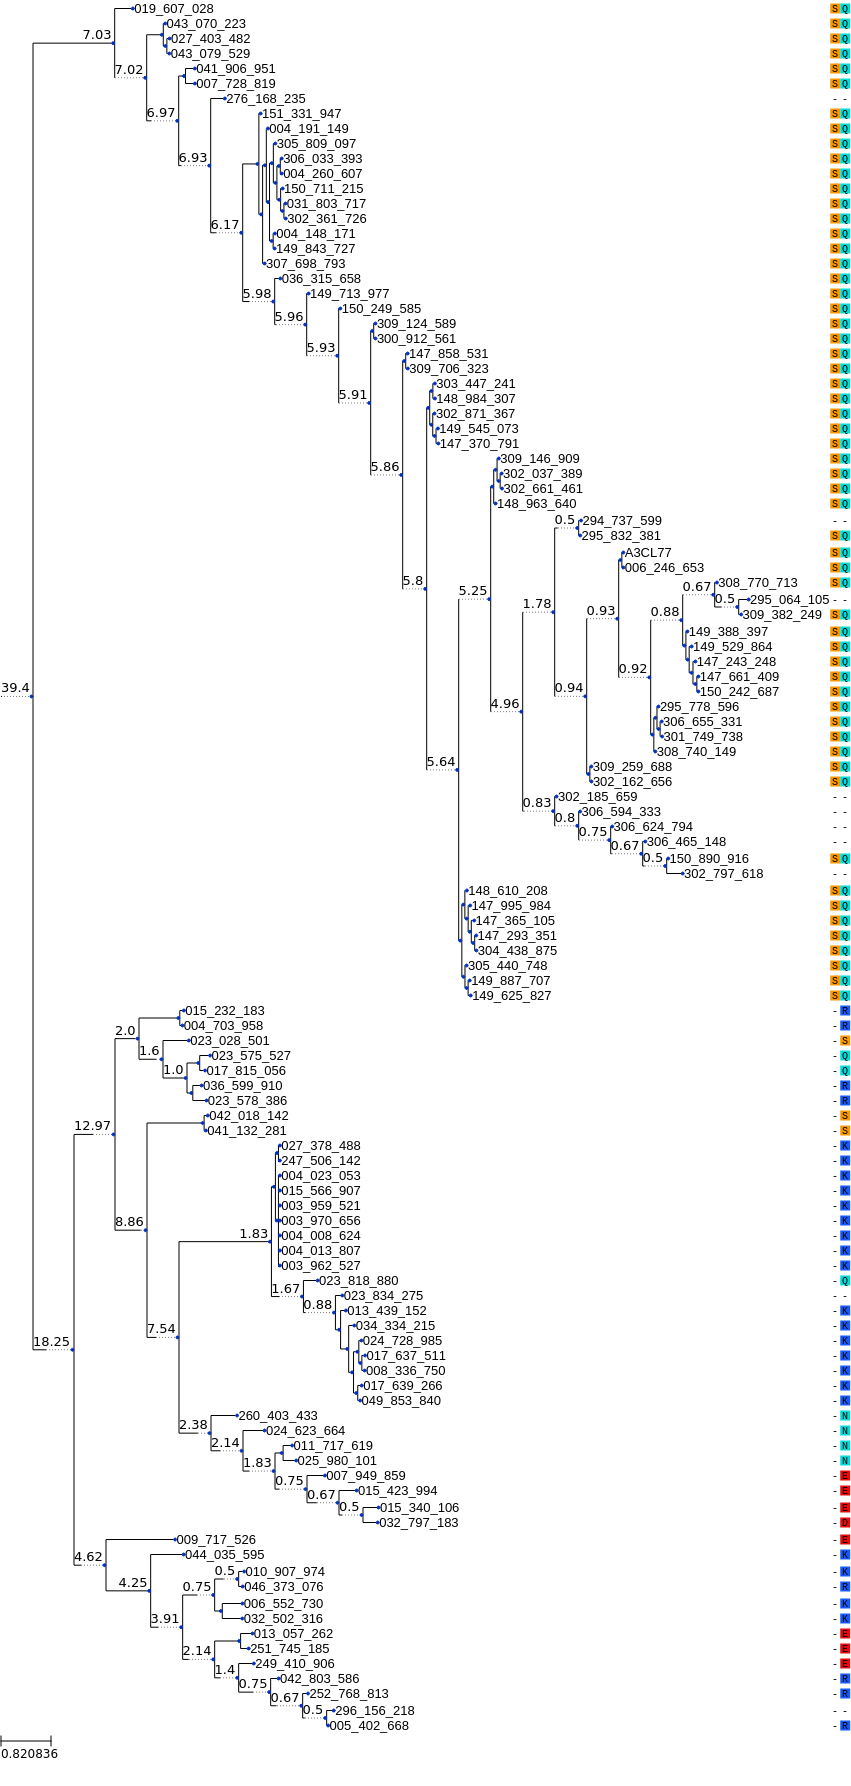

In [94]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    if leaf.name in leaf_delete_list:
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "whole_annotation_all_vs_all"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score > 0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree_deleted.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

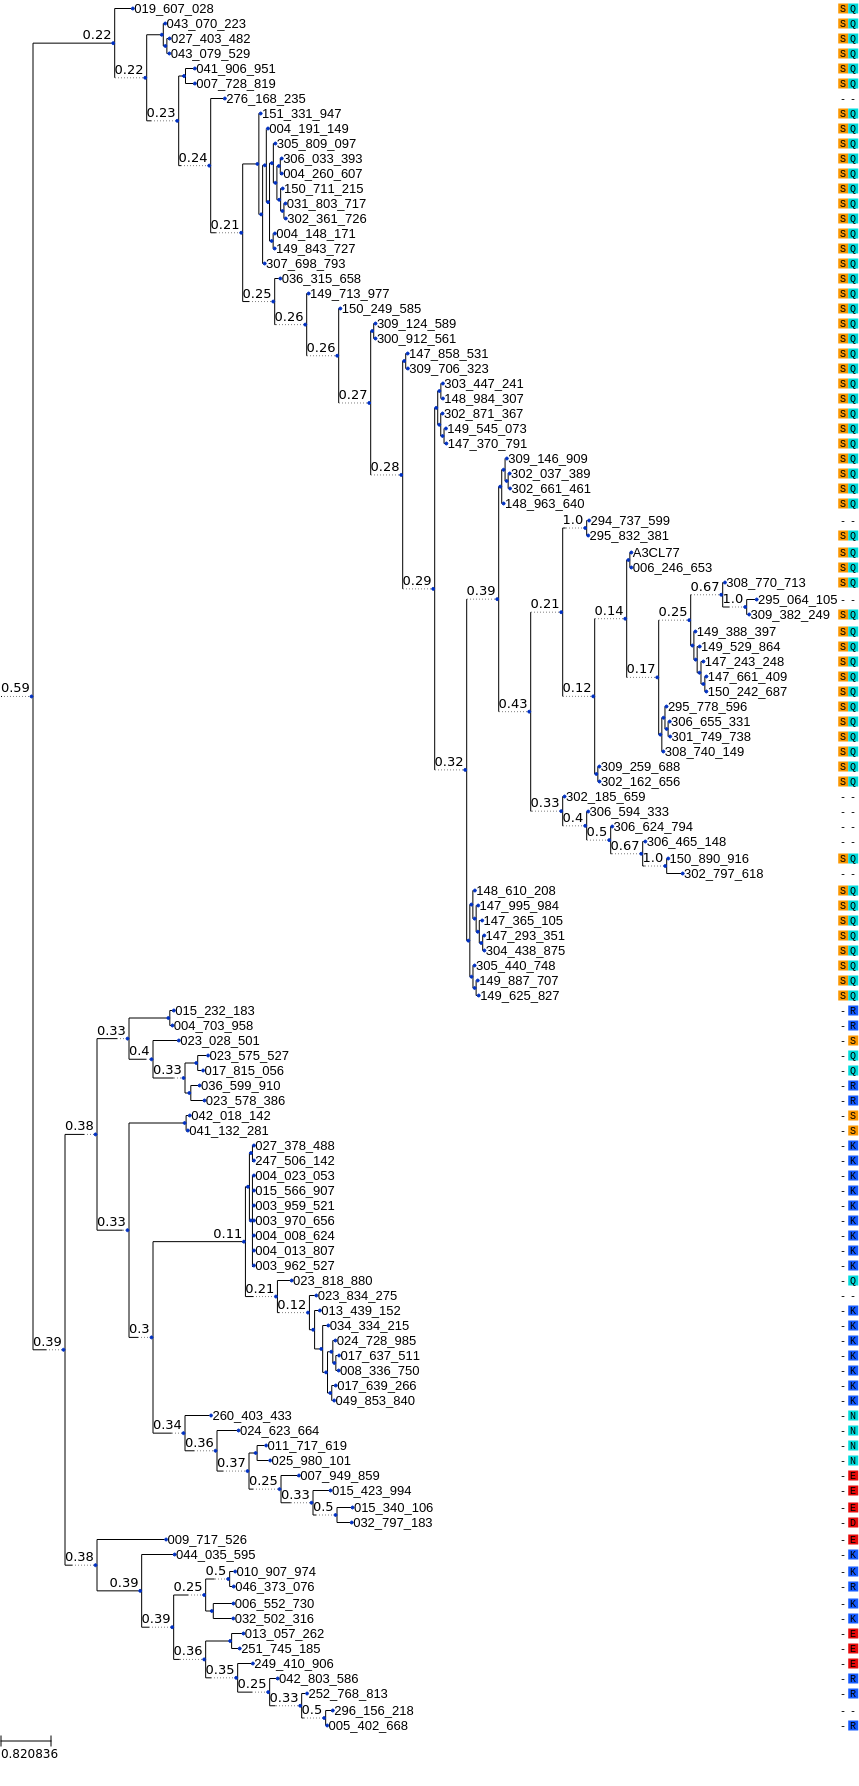

In [98]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    if leaf.name in leaf_delete_list:
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "all_vs_all_means"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score > 0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree_deleted.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

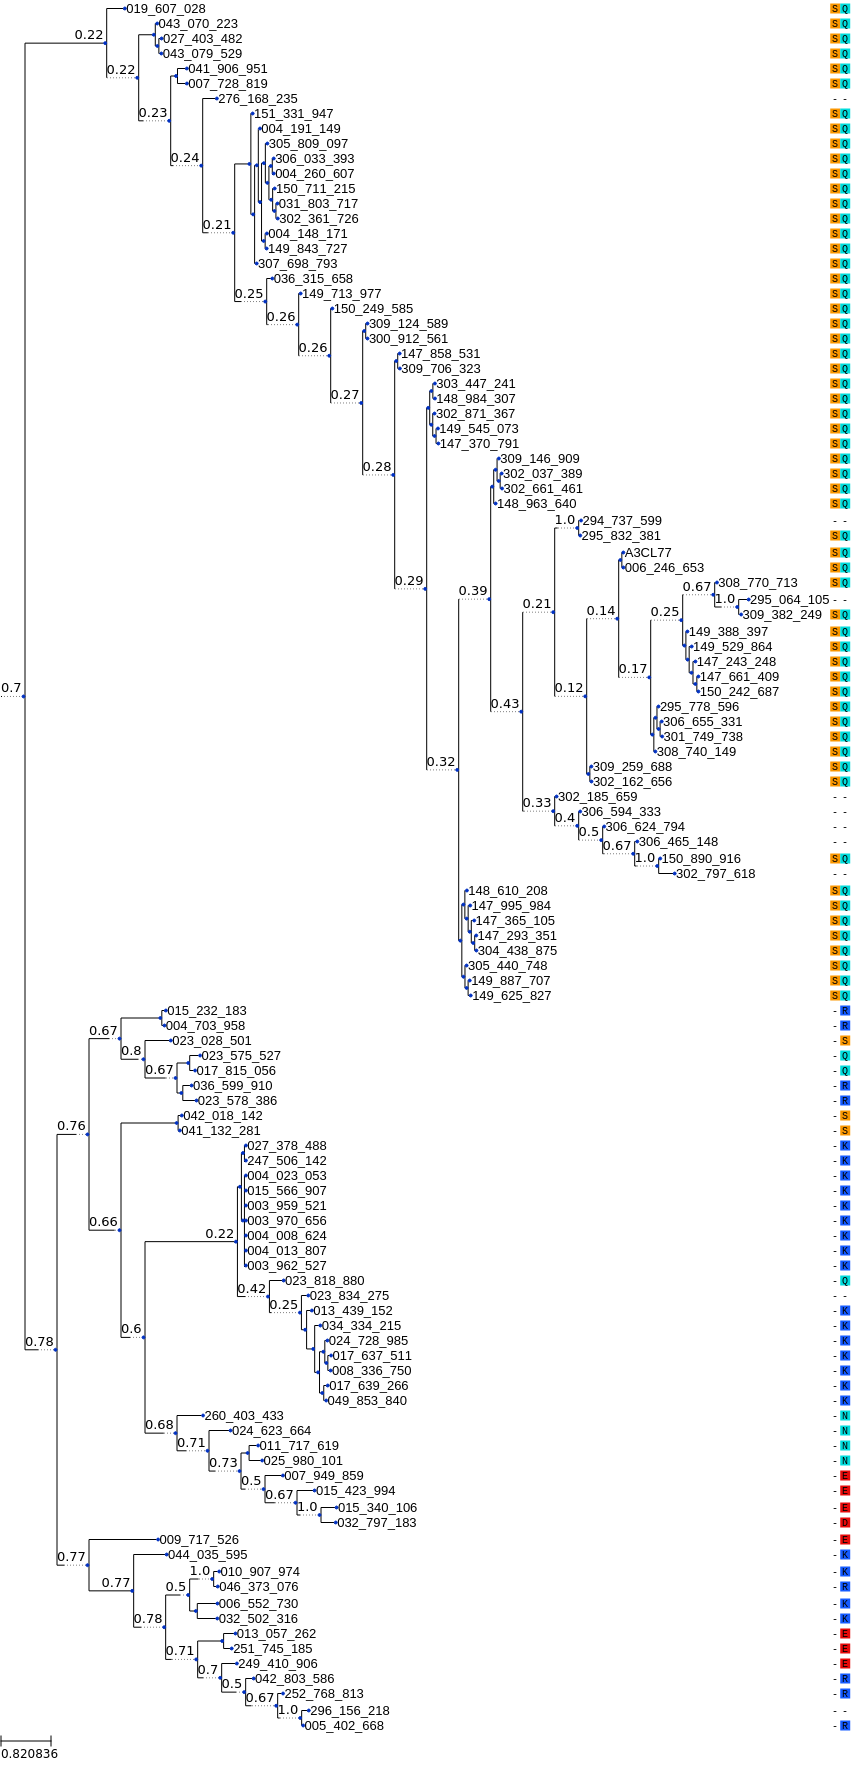

In [101]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")
md = tree.get_midpoint_outgroup()
tree.set_outgroup(md)

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    if leaf.name in leaf_delete_list:
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "whole_annotation_all_vs_all_means"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score > 0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree_deleted.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

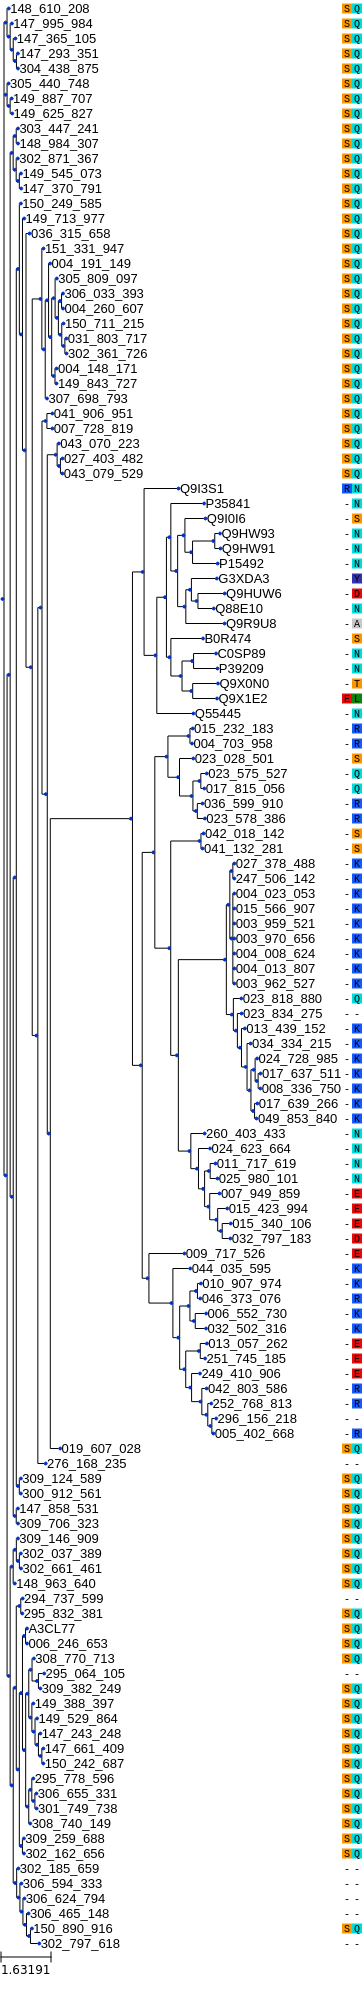

In [34]:
# ### VISUALIZING THE TREE ###
## VERSION ANTIGUA; ESTO ES PARA BORRAR
# from ete3 import PhyloTree, TreeStyle, SeqMotifFace
# tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

# ts = TreeStyle()
# ts.layout_fn = lambda x: True

# for leaf in tree.iter_leaves():
#     draw_position = 0
#     for position in position_matrix:
#         seqFace = SeqMotifFace(leaf.sequence[position], seq_format="seq")
#         (tree&leaf.name).add_face(seqFace, draw_position, "aligned")
#         draw_position += 1

# tree.render('%%inline', tree_style = ts)
# # tree.show(tree_style = ts)